In [17]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout,Dense,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras import optimizers



In [18]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [19]:
#load the data

training_set = pd.read_csv('fashion-mnist_train.csv')
testing_set = pd.read_csv('fashion-mnist_test.csv')



In [20]:
#Preprocess the data 
# Reshape the given csv into the original images


# Creation of validation dataset to improve model performance evalutation
X = np.array(training_set.iloc[:,1:])
X = X.reshape(X.shape[0],28,28,1).astype('float32')
X = X/255
y = to_categorical(np.array(training_set.iloc[:,0])) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=seed)

X_test = np.array(testing_set.iloc[:,1:])
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')
X_test = X_test/255
y_test = to_categorical(np.array(testing_set.iloc[:,0]))


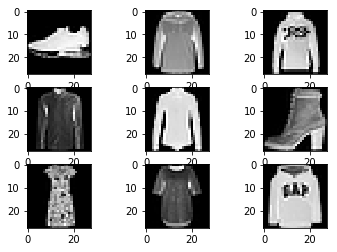

In [21]:
# Check if the reshaping worked by displaying the 9 first images 

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(np.squeeze(X_train[i]), cmap='gray')
plt.show()

In [22]:
# Building a cnn model
shape = (28,28,1)
number_of_classes = y_test.shape[1]
def create_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation ='relu',input_shape = shape ))
    model.add(Conv2D(32,(3,3),activation ='relu',input_shape = shape ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3),activation ='relu' ))
    model.add(Conv2D(64,(3,3),activation ='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(optimizer= 'adam' ,loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [23]:
# Early stopping to save the best model 
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),ModelCheckpoint('best_cnn.h5', monitor='val_loss', save_best_only=True)]

In [8]:
# Training the model
batch_size = 150
epochs = 20
model = create_model()
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks,
                    verbose=1,
validation_data=(X_val, y_val))

Train on 40200 samples, validate on 19800 samples
Epoch 1/20
40200/40200 [==============================] - 485s 12ms/step - loss: 0.5295 - acc: 0.8088 - val_loss: 2.2386 - val_acc: 0.2062
Epoch 2/20
40200/40200 [==============================] - 406s 10ms/step - loss: 0.3479 - acc: 0.8728 - val_loss: 0.5475 - val_acc: 0.7865
Epoch 3/20
40200/40200 [==============================] - 365s 9ms/step - loss: 0.2932 - acc: 0.8938 - val_loss: 0.2723 - val_acc: 0.8991
Epoch 4/20
40200/40200 [==============================] - 333s 8ms/step - loss: 0.2607 - acc: 0.9047 - val_loss: 0.2684 - val_acc: 0.9029
Epoch 5/20
40200/40200 [==============================] - 325s 8ms/step - loss: 0.2391 - acc: 0.9125 - val_loss: 0.2390 - val_acc: 0.9114
Epoch 6/20
40200/40200 [==============================] - 371s 9ms/step - loss: 0.2164 - acc: 0.9208 - val_loss: 0.2392 - val_acc: 0.9112
Epoch 7/20
40200/40200 [==============================] - 411s 10ms/step - loss: 0.2063 - acc: 0.9240 - val_loss: 0.2336

In [25]:
# Evaluate the best model

best_model = load_model('best_cnn2.h5')
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.212055019379
Test accuracy: 0.9304


In [26]:
# Make predictions about the classes
predictions = best_model.predict_classes(X_test,batch_size=150)  


In [19]:
# Save the classification

filename = 'best_cnn_classification.csv';
PictureID = list(range(1,len(predictions)+1))
submission = pd.DataFrame({'Clothe_category':predictions })
submission.to_csv(filename,header = True, index = False)
print('Saved file: ' + filename)

Saved file: best_cnn_classification.csv


In [10]:
# Data Model visualization
print(best_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
__________

In [27]:
# Studying misclassfications

target_names = ["Class {}".format(i) for i in range(number_of_classes)]
y_true = testing_set.iloc[:,0]

print(classification_report(y_true, predictions, target_names=target_names))



             precision    recall  f1-score   support

    Class 0       0.87      0.88      0.87      1000
    Class 1       0.99      0.99      0.99      1000
    Class 2       0.90      0.89      0.89      1000
    Class 3       0.94      0.94      0.94      1000
    Class 4       0.91      0.90      0.91      1000
    Class 5       0.99      0.97      0.98      1000
    Class 6       0.80      0.80      0.80      1000
    Class 7       0.96      0.97      0.96      1000
    Class 8       0.97      0.99      0.98      1000
    Class 9       0.96      0.98      0.97      1000

avg / total       0.93      0.93      0.93     10000



In [28]:
print(confusion_matrix(y_true, predictions))

[[877   1  15   7   2   0  88   0  10   0]
 [  1 986   0   9   1   1   2   0   0   0]
 [ 19   1 887  11  23   0  54   0   5   0]
 [ 15   6   3 944  16   0  14   0   2   0]
 [  0   1  41  19 902   0  36   0   1   0]
 [  0   0   0   0   0 974   0  16   1   9]
 [ 90   0  36  18  46   0 802   0   8   0]
 [  0   0   0   0   0   4   0 967   0  29]
 [  4   0   1   1   1   1   2   0 989   1]
 [  0   0   0   0   0   2   0  22   0 976]]


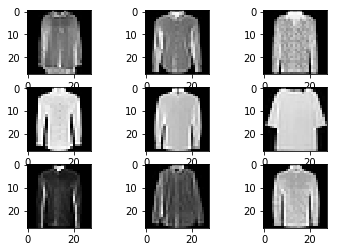

In [17]:
#Let's display actual shirts
y_true = np.array(y_true)
shirt = predictions == 6
acurate_prediction = predictions == y_true 
real_shirt = np.nonzero( shirt & acurate_prediction)[0] 
for i, real_shirt in enumerate(real_shirt[:9]):
    plt.subplot(330 + 1 + i)
    plt.imshow(np.squeeze(X_test[real_shirt]), cmap='gray')
plt.show()

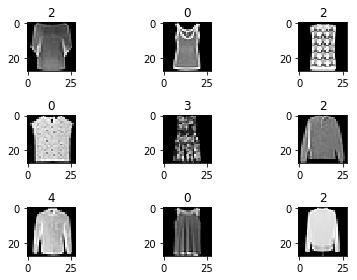

In [18]:
# Let's display misclassified shirts
y_true = np.array(y_true)
shirt = predictions == 6
prediction_error = predictions!=y_true 
fake_shirt = np.nonzero( shirt & prediction_error)[0] 

for i, fake_shirt in enumerate(fake_shirt[:9]):
    #plt.subplot(440 + 1 + i)
    plt.subplot(3,3,i+1)
    #plt.subplot(10,5,i+1)
    plt.imshow(np.squeeze(X_test[fake_shirt]), cmap='gray')
    #plt.title("Predicted class {}, Actual Class {}".format(predictions[fake_shirt], y_true[fake_shirt]))
    plt.title(y_true[fake_shirt])
    
#figure = plt.gcf()
plt.tight_layout()
plt.show()
#figure.savefig('misclassification.png')    
    